In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display

In [2]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
os.getcwd()

'/app/experiments'

In [4]:
# folder = 'D:/MITB Analytics/2025 Aug Term/MLE/cs611-mle-mitb/assignment/data/'
folder = '/app/data/'

In [5]:
feature_clickstream = pd.read_csv(folder + "feature_clickstream.csv")
features_attributes = pd.read_csv(folder + "features_attributes.csv")
features_financials = pd.read_csv(folder + "features_financials.csv")
lms_loan_daily = pd.read_csv(folder + "lms_loan_daily.csv")

# Exploration

## Functions

### Load Datasets

In [6]:
def load_and_explore_datasets():
    """
    Load all datasets and perform comprehensive data exploration
    """

    datasets = {}
    filenames = ['feature_clickstream.csv', 'features_attributes.csv', 'features_financials.csv', 'lms_loan_daily.csv']
    
    for filename in filenames:
        try:
            df = pd.read_csv(folder + filename)
            datasets[filename.replace('.csv', '')] = df
            print(f"✓ {filename}: {df.shape[0]} rows, {df.shape[1]} columns")
            display(df.head(20))
        except Exception as e:
            print(f"✗ Error loading {filename}: {e}")
    
    return datasets

### Data Quality

In [7]:
def analyze_data_quality(datasets):
    """
    Comprehensive data quality analysis
    """  
    
    for name, df in datasets.items():
        print("\n" + "=" * 60)
        print(f"--- {name.upper()} DATASET ---")
        print("=" * 60)
        
        # Basic info
        print(f"Shape: {df.shape}")
        print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")

        # Columns details
        print(f"Columns: {df.dtypes}")
        
        # Missing values
        missing_values = df.isnull().sum()
        missing_pct = (missing_values / len(df)) * 100
        missing_df = pd.DataFrame({
            'Missing_Count': missing_values,
            'Missing_Percentage': missing_pct
        })
        missing_df = missing_df[missing_df.Missing_Count > 0].sort_values('Missing_Count', ascending=False)
        
        if not missing_df.empty:
            print("\nMissing Values:")
            print(missing_df)
        else:
            print("\n✓ No missing values found")
                
        # Duplicates
        duplicates = df.duplicated().sum()
        print(f"\nDuplicate rows: {duplicates}")
        
        # Unique customers
        if 'Customer_ID' in df.columns:
            unique_customers = df['Customer_ID'].nunique()
            total_records = len(df)
            print(f"Unique customers: {unique_customers}")
            print(f"Records per customer (avg): {total_records/unique_customers:.2f}")

### Customer Coverage

In [8]:
def analyze_customer_coverage(datasets):
    """
    Analyze customer coverage across datasets
    """
    customer_sets = {}
    for name, df in datasets.items():
        if 'Customer_ID' in df.columns:
            customer_sets[name] = set(df['Customer_ID'].unique())
            print(f"{name}: {len(customer_sets[name])} unique customers")
    
    # Find intersection of all datasets
    all_datasets = list(customer_sets.keys())
    if len(all_datasets) > 1:
        intersection = customer_sets[all_datasets[0]]
        for dataset in all_datasets[1:]:
            intersection = intersection.intersection(customer_sets[dataset])
        
        print(f"\nCustomers present in ALL datasets: {len(intersection)}")
        
        # Create coverage matrix
        all_customers = set()
        for customers in customer_sets.values():
            all_customers.update(customers)
        
        coverage_matrix = []
        for customer in sorted(all_customers):
            row = [customer]
            for dataset in all_datasets:
                row.append('✓' if customer in customer_sets[dataset] else '✗')
            coverage_matrix.append(row)
        
        coverage_df = pd.DataFrame(coverage_matrix, 
                                 columns=['Customer_ID'] + all_datasets)
        print(f"\nTotal unique customers across all datasets: {len(all_customers)}")

### Temporal patterns

In [9]:
def analyze_temporal_patterns(datasets):
    """
    Analyze temporal patterns in the data
    """    
    for name, df in datasets.items():
        if 'snapshot_date' in df.columns:
            
            print("\n" + "=" * 60)
            print(f"--- {name.upper()} TEMPORAL PATTERNS ---")
            print("=" * 60)
            
            # Convert to datetime
            df['snapshot_date'] = pd.to_datetime(df['snapshot_date'])
            
            # Date range
            date_range = df['snapshot_date'].agg(['min', 'max'])
            print(f"Date range: {date_range['min'].strftime('%Y-%m-%d')} to {date_range['max'].strftime('%Y-%m-%d')}")
            
            # Unique dates
            unique_dates = df['snapshot_date'].nunique()
            print(f"Unique snapshot dates: {unique_dates}")
            
            # Records per date
            records_per_date = df['snapshot_date'].value_counts().sort_index()
            print(f"Records per date (sample):")
            print(records_per_date)

### Loan Default Indicators

In [10]:
def analyze_loan_default_indicators(datasets):
    """
    Identify potential loan default indicators
    """
    print("\n" + "=" * 60)
    print("LOAN DEFAULT INDICATORS ANALYSIS")
    print("=" * 60)
    
    # Analyze loans dataset for default patterns
    if 'lms_loan_daily' in datasets:
        loans_df = datasets['lms_loan_daily']
        print("\n--- LOAN PAYMENT PATTERNS ---")
        
        # Overdue analysis
        loans_df['has_overdue'] = loans_df['overdue_amt'] > 0
        overdue_summary = loans_df['has_overdue'].value_counts()
        print(f"Records with overdue amounts: {overdue_summary}")
        
        if overdue_summary.get(True, 0) > 0:
            print(f"\nOverdue amount statistics:")
            overdue_stats = loans_df[loans_df['has_overdue']]['overdue_amt'].describe()
            print(overdue_stats)
        
        # Payment ratio analysis
        loans_df['payment_ratio'] = loans_df['paid_amt'] / loans_df['due_amt'].replace(0, np.nan)
        payment_stats = loans_df['payment_ratio'].describe()
        print(f"\nPayment ratio statistics (paid/due):")
        print(payment_stats)
        
        # Identify potential defaulters
        loans_df['potential_default'] = (
            (loans_df['overdue_amt'] > 0) | 
            (loans_df['payment_ratio'] < 0.5)
        )
        default_summary = loans_df['potential_default'].value_counts()
        print(f"\nPotential default indicators:")
        print(default_summary)
    
    # Analyze financial indicators
    if 'financials' in datasets:
        fin_df = datasets['financials']
        print(f"\n--- FINANCIAL RISK INDICATORS ---")
        
        # Credit mix analysis
        if 'Credit_Mix' in fin_df.columns:
            credit_mix = fin_df['Credit_Mix'].value_counts()
            print(f"\nCredit Mix distribution:")
            print(credit_mix)
        
        # Payment behavior analysis
        if 'Payment_Behaviour' in fin_df.columns:
            payment_behavior = fin_df['Payment_Behaviour'].value_counts()
            print(f"\nPayment Behavior distribution:")
            print(payment_behavior)
        
        # Delay analysis
        if 'Delay_from_due_date' in fin_df.columns:
            delay_stats = fin_df['Delay_from_due_date'].describe()
            print(f"\nDelay from due date statistics:")
            print(delay_stats)
        
        # High-risk indicators
        risk_indicators = []
        if 'Credit_Mix' in fin_df.columns:
            risk_indicators.append(fin_df['Credit_Mix'] == 'Bad')
        if 'Delay_from_due_date' in fin_df.columns:
            risk_indicators.append(fin_df['Delay_from_due_date'] > 30)
        if 'Credit_Utilization_Ratio' in fin_df.columns:
            risk_indicators.append(fin_df['Credit_Utilization_Ratio'] > 80)
        
        if risk_indicators:
            high_risk_mask = pd.concat(risk_indicators, axis=1).any(axis=1)
            print(f"\nCustomers with high-risk indicators: {high_risk_mask.sum()}/{len(fin_df)}")


### Feature Distribution

In [11]:
def analyze_feature_distributions(datasets):
    """
    Analyze key feature distributions
    """
    
    for name, df in datasets.items():
        print("\n" + "=" * 60)
        print(f"--- {name.upper()} KEY FEATURES ---")
        print("=" * 60)
        
        # Numerical features
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            print(f"\nNumerical features summary:")
            display(df[numeric_cols].describe())
        
        # Categorical features
        categorical_cols = df.select_dtypes(include=['object']).columns
        categorical_cols = [col for col in categorical_cols 
                    if col not in ['Customer_ID', 'Name', 'SSN'] 
                    and not col.endswith('_id')]
        
        if len(categorical_cols) > 0:
            print(f"\nCategorical features:")
            for col in categorical_cols[:5]:  # Show first 5 categorical columns
                print(f"\n{col}:")
                print(df[col].value_counts().head(10))

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def analyze_feature_distributions(datasets, bins=50, clip_percentiles=(1, 99), max_cols_per_row=3):
    """
    Show summaries and plot histograms for all numerical features in each dataset.

    Params
    ------
    datasets : dict[str, pd.DataFrame]
        Mapping of dataset name -> pandas DataFrame
    bins : int
        Histogram bins
    clip_percentiles : tuple[int, int] or None
        If set, clip each numeric series to these percentiles to reduce long-tail distortion.
        Set to None to disable clipping.
    max_cols_per_row : int
        How many histogram subplots per row
    """

    for name, df in datasets.items():
        print("\n" + "=" * 60)
        print(f"--- {name.upper()} KEY FEATURES ---")
        print("=" * 60)

        # Identify columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        categorical_cols = [c for c in categorical_cols
                            if c not in ['Customer_ID', 'Name', 'SSN']
                            and not c.lower().endswith('_id')]

        # Numerical summary
        if numeric_cols:
            print("\nNumerical features summary:")
            display(df[numeric_cols].describe())

            # Histograms
            n = len(numeric_cols)
            n_cols = min(max_cols_per_row, n)
            n_rows = ceil(n / n_cols)

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
            if n_rows == 1 and n_cols == 1:
                axes = np.array([[axes]])
            elif n_rows == 1:
                axes = np.array([axes])
            elif n_cols == 1:
                axes = np.array([[ax] for ax in axes])

            axes_flat = axes.ravel()

            for i, col in enumerate(numeric_cols):
                ax = axes_flat[i]
                s = df[col].dropna()

                # Optional clipping to reduce extreme-tail compression
                if clip_percentiles is not None and len(s) > 0:
                    lo, hi = np.percentile(s, clip_percentiles)
                    s = s.clip(lower=lo, upper=hi)

                ax.hist(s, bins=bins)
                ax.set_title(col)
                ax.set_xlabel(col)
                ax.set_ylabel("Count")

                # Mean/median guides
                if len(s) > 0:
                    mean_v = s.mean()
                    med_v = s.median()
                    ax.axvline(mean_v, linestyle='--', linewidth=1, label=f"mean={mean_v:,.2f}")
                    ax.axvline(med_v, linestyle=':', linewidth=1, label=f"median={med_v:,.2f}")
                    ax.legend()

            # Hide any unused axes
            for j in range(len(numeric_cols), len(axes_flat)):
                axes_flat[j].axis('off')

            plt.tight_layout()
            plt.show()

        # Categorical preview
        if categorical_cols:
            print("\nCategorical features:")
            for col in categorical_cols[:5]:  # preview first 5
                print(f"\n{col}:")
                print(df[col].value_counts(dropna=False).head(10))


### Data Issues

feature_clickstream = pd.read_csv(folder + "feature_clickstream.csv")
features_attributes = pd.read_csv(folder + "features_attributes.csv")
features_financials = pd.read_csv(folder + "features_financials.csv")
lms_loan_daily = pd.read_csv(folder + "lms_loan_daily.csv")

In [12]:
lms_loan_daily.head()

,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date
0,CUS_0x1000_2023_05_01,CUS_0x1000,01/05/2023,10,0,10000,0,0,0,10000,01/05/2023
1,CUS_0x1000_2023_05_01,CUS_0x1000,01/05/2023,10,1,10000,1000,1000,0,9000,01/06/2023
2,CUS_0x1000_2023_05_01,CUS_0x1000,01/05/2023,10,2,10000,1000,1000,0,8000,01/07/2023
3,CUS_0x1000_2023_05_01,CUS_0x1000,01/05/2023,10,3,10000,1000,0,1000,8000,01/08/2023
4,CUS_0x1000_2023_05_01,CUS_0x1000,01/05/2023,10,4,10000,1000,2000,0,6000,01/09/2023


In [13]:
def identify_data_issues(datasets):
    """
    Identify potential data quality issues
    """
    
    issues_found = []
    
    for name, df in datasets.items():
        print("\n" + "=" * 60)
        print(f"\n--- {name.upper()} ISSUES ---")
        print("=" * 60)
        
        # Check for negative values where they shouldn't be
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if 'amount' in col.lower() or 'balance' in col.lower() or 'income' in col.lower():
                negative_count = (df[col] < 0).sum()
                if negative_count > 0:
                    print(f"⚠ {col}: {negative_count} negative values")
                    issues_found.append(f"{name}.{col}: negative values")
        
        # Check for outliers using IQR method
        for col in numeric_cols:
            if col not in ['Customer_ID', 'Age']:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
                if outliers > len(df) * 0.1:  # More than 10% outliers
                    print(f"⚠ {col}: {outliers} potential outliers ({outliers/len(df)*100:.1f}%)")
                    issues_found.append(f"{name}.{col}: high outlier count")
        
        # Check for inconsistent data formats
        if 'snapshot_date' in df.columns:
            try:
                pd.to_datetime(df['snapshot_date'])
            except:
                print(f"⚠ snapshot_date: inconsistent date formats")
                issues_found.append(f"{name}.snapshot_date: format issues")
    
    if not issues_found:
        print("\n✓ No major data quality issues detected!")
    else:
        print(f"\n📋 Summary: {len(issues_found)} potential issues identified")

## Comprehensive Exploration

### Load Datasets

In [14]:
datasets = load_and_explore_datasets()

✓ feature_clickstream.csv: 215376 rows, 22 columns


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,fe_11,fe_12,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,63,118,80,121,55,193,111,112,-101,83,164,105,-16,-81,-126,114,35,85,-73,76,CUS_0x1037,2023-01-01
1,-108,182,123,4,-56,27,25,-6,284,222,203,190,-14,-96,200,35,130,94,111,75,CUS_0x1069,2023-01-01
2,-13,8,87,166,214,-98,215,152,129,139,14,203,26,86,171,125,-130,354,17,302,CUS_0x114a,2023-01-01
3,-85,45,200,89,128,54,76,51,61,139,6,197,172,96,174,163,37,207,180,118,CUS_0x1184,2023-01-01
4,55,120,226,-86,253,97,107,68,103,126,34,12,76,43,183,159,-26,104,118,184,CUS_0x1297,2023-01-01
5,-133,114,138,84,53,-60,60,128,349,102,-70,-138,200,168,32,-85,91,185,134,-28,CUS_0x12fb,2023-01-01
6,67,155,24,-16,205,80,355,140,201,87,130,86,71,72,78,238,96,147,51,155,CUS_0x1325,2023-01-01
7,-64,93,36,-1,3,183,-129,122,164,138,60,140,143,90,354,280,121,159,-81,-27,CUS_0x1341,2023-01-01
8,167,37,169,155,4,151,99,192,-64,-207,63,241,167,43,216,287,115,183,66,55,CUS_0x1375,2023-01-01
9,356,-23,-4,-46,80,167,258,174,104,65,133,-75,145,211,140,113,31,136,36,125,CUS_0x13a8,2023-01-01


✓ features_attributes.csv: 12500 rows, 6 columns


,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
0,CUS_0x1000,Alistair Barrf,18,913-74-1218,Lawyer,2023-05-01
1,CUS_0x1009,Arunah,26,063-67-6938,Mechanic,2025-01-01
2,CUS_0x100b,Shirboni,19,#F%$D@*&8,Media_Manager,2024-03-01
3,CUS_0x1011,Schneyerh,44,793-05-8223,Doctor,2023-11-01
4,CUS_0x1013,Cameront,44,930-49-9615,Mechanic,2023-12-01
5,CUS_0x1015,Holtono,27,810-97-7024,Journalist,2023-08-01
6,CUS_0x1018,Felsenthalq,15,731-19-8119,Accountant,2023-11-01
7,CUS_0x1026,Josephv,52,500-62-9044,Manager,2023-10-01
8,CUS_0x102d,Neil Chatterjeex,31,692-71-7552,Entrepreneur,2024-01-01
9,CUS_0x102e,Rhysn,26,#F%$D@*&8,Scientist,2024-04-01


✓ features_financials.csv: 12500 rows, 22 columns


,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date
0,CUS_0x1000,30625.94,2706.161667,6,5,27,2,"Credit-Builder Loan, and Home Equity Loan",57,26,1.63,11.0,Bad,1562.91,30.077191,10 Years and 9 Months,Yes,42.941090,77.31427572208112,High_spent_Medium_value_payments,400.36080052211616,2023-05-01
1,CUS_0x1009,52312.68_,4250.390000,6,5,17,4,"Not Specified, Home Equity Loan, Credit-Builde...",5,18,9.73,4.0,_,202.68,40.286997,31 Years and 0 Months,Yes,108.366467,58.66019164829086,High_spent_Medium_value_payments,508.01234122645366,2025-01-01
2,CUS_0x100b,113781.38999999998,9549.782500,1,4,1,0,NaN,14,8,8.34,4.0,Good,1030.2,28.592943,15 Years and 10 Months,No,0.000000,617.0792665202719,High_spent_Small_value_payments,597.8989834797281,2024-03-01
3,CUS_0x1011,58918.47,5208.872500,3,3,17,3,"Student Loan, Credit-Builder Loan, and Debt Co...",27,13,14.42,7.0,Standard,473.14,27.829959,15 Years and 10 Months,Yes,123.434939,383.35084463651407,Low_spent_Medium_value_payments,294.1014665671429,2023-11-01
4,CUS_0x1013,98620.98,7962.415000,3,3,6,3,"Student Loan, Debt Consolidation Loan, and Per...",12,9,1.33,3.0,Good,1233.51,26.524864,17 Years and 10 Months,No,228.018084,332.3337079767732,High_spent_Medium_value_payments,485.8897083704929,2023-12-01
5,CUS_0x1015,46951.02,3725.585000,7,4,16,0,NaN,8,9,15.83,9.0,Standard,340.22,38.682232,21 Years and 5 Months,NM,0.000000,437.4339945818671,Low_spent_Small_value_payments,225.12450541813288,2023-08-01
6,CUS_0x1018,61194.81,5014.567500,7,7,23,8,"Credit-Builder Loan, Payday Loan, Home Equity ...",19,22,28.63,8.0,Bad,2773.09,27.268458,14 Years and 3 Months,Yes,225.368691,166.53062988488216,High_spent_Medium_value_payments,359.55742873867035,2023-11-01
7,CUS_0x1026,170614.28,14463.856667,2,6,9,2,"Payday Loan, and Auto Loan",0,5,0.73,3.0,Good,849.69,31.757521,20 Years and 8 Months,No,208.907479,184.27787149576235,High_spent_Medium_value_payments,1303.2003157888887,2023-10-01
8,CUS_0x102d,89064.52,7256.043333,5,3,1,1,Mortgage Loan,6,5,6.37,3.0,_,648.36,30.574299,30 Years and 3 Months,No,37.572751,296.09411909412466,High_spent_Medium_value_payments,641.9374636584146,2024-01-01
9,CUS_0x102e,50807.44,4197.953333,8,4,11,4,"Mortgage Loan, Not Specified, Home Equity Loan...",12,9,2.6,4.0,_,869.59,30.311454,22 Years and 10 Months,NM,88.759919,65.27556452739218,High_spent_Medium_value_payments,515.7598495584575,2024-04-01


✓ lms_loan_daily.csv: 137500 rows, 11 columns


,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date
0,CUS_0x1000_2023_05_01,CUS_0x1000,01/05/2023,10,0,10000,0,0,0,10000,01/05/2023
1,CUS_0x1000_2023_05_01,CUS_0x1000,01/05/2023,10,1,10000,1000,1000,0,9000,01/06/2023
2,CUS_0x1000_2023_05_01,CUS_0x1000,01/05/2023,10,2,10000,1000,1000,0,8000,01/07/2023
3,CUS_0x1000_2023_05_01,CUS_0x1000,01/05/2023,10,3,10000,1000,0,1000,8000,01/08/2023
4,CUS_0x1000_2023_05_01,CUS_0x1000,01/05/2023,10,4,10000,1000,2000,0,6000,01/09/2023
5,CUS_0x1000_2023_05_01,CUS_0x1000,01/05/2023,10,5,10000,1000,0,1000,6000,01/10/2023
6,CUS_0x1000_2023_05_01,CUS_0x1000,01/05/2023,10,6,10000,1000,0,2000,6000,01/11/2023
7,CUS_0x1000_2023_05_01,CUS_0x1000,01/05/2023,10,7,10000,1000,0,3000,6000,01/12/2023
8,CUS_0x1000_2023_05_01,CUS_0x1000,01/05/2023,10,8,10000,1000,0,4000,6000,01/01/2024
9,CUS_0x1000_2023_05_01,CUS_0x1000,01/05/2023,10,9,10000,1000,0,5000,6000,01/02/2024


### Data Quality

In [15]:
analyze_data_quality(datasets)


--- FEATURE_CLICKSTREAM DATASET ---
Shape: (215376, 22)
Memory usage: 58458.50 KB
Columns: fe_1              int64
fe_2              int64
fe_3              int64
fe_4              int64
fe_5              int64
fe_6              int64
fe_7              int64
fe_8              int64
fe_9              int64
fe_10             int64
fe_11             int64
fe_12             int64
fe_13             int64
fe_14             int64
fe_15             int64
fe_16             int64
fe_17             int64
fe_18             int64
fe_19             int64
fe_20             int64
Customer_ID      object
snapshot_date    object
dtype: object

✓ No missing values found

Duplicate rows: 0
Unique customers: 8974
Records per customer (avg): 24.00

--- FEATURES_ATTRIBUTES DATASET ---
Shape: (12500, 6)
Memory usage: 4213.16 KB
Columns: Customer_ID      object
Name             object
Age              object
SSN              object
Occupation       object
snapshot_date    object
dtype: object

✓ No missing va

### Customer Coverage

In [16]:
analyze_customer_coverage(datasets)

feature_clickstream: 8974 unique customers
features_attributes: 12500 unique customers
features_financials: 12500 unique customers
lms_loan_daily: 12500 unique customers

Customers present in ALL datasets: 8974

Total unique customers across all datasets: 12500


### Temporal Patterns

In [17]:
analyze_temporal_patterns(datasets)


--- FEATURE_CLICKSTREAM TEMPORAL PATTERNS ---
Date range: 2023-01-01 to 2024-12-01
Unique snapshot dates: 24
Records per date (sample):
snapshot_date
2023-01-01    8974
2023-02-01    8974
2023-03-01    8974
2023-04-01    8974
2023-05-01    8974
2023-06-01    8974
2023-07-01    8974
2023-08-01    8974
2023-09-01    8974
2023-10-01    8974
2023-11-01    8974
2023-12-01    8974
2024-01-01    8974
2024-02-01    8974
2024-03-01    8974
2024-04-01    8974
2024-05-01    8974
2024-06-01    8974
2024-07-01    8974
2024-08-01    8974
2024-09-01    8974
2024-10-01    8974
2024-11-01    8974
2024-12-01    8974
Name: count, dtype: int64

--- FEATURES_ATTRIBUTES TEMPORAL PATTERNS ---
Date range: 2023-01-01 to 2025-01-01
Unique snapshot dates: 25
Records per date (sample):
snapshot_date
2023-01-01    530
2023-02-01    501
2023-03-01    506
2023-04-01    510
2023-05-01    521
2023-06-01    517
2023-07-01    471
2023-08-01    481
2023-09-01    454
2023-10-01    487
2023-11-01    491
2023-12-01    489


### Loan Default Indicators

In [18]:
analyze_loan_default_indicators(datasets)


LOAN DEFAULT INDICATORS ANALYSIS

--- LOAN PAYMENT PATTERNS ---
Records with overdue amounts: has_overdue
False    108624
True      28876
Name: count, dtype: int64

Overdue amount statistics:
count    28876.000000
mean      4151.786951
std       2341.063641
min       1000.000000
25%       2000.000000
50%       4000.000000
75%       6000.000000
max      10000.000000
Name: overdue_amt, dtype: float64

Payment ratio statistics (paid/due):
count    125000.000000
mean          0.782992
std           0.451430
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: payment_ratio, dtype: float64

Potential default indicators:
potential_default
False    108624
True      28876
Name: count, dtype: int64


### Feature Distribution


--- FEATURE_CLICKSTREAM KEY FEATURES ---

Numerical features summary:


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,fe_11,fe_12,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20
count,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000
mean,101.414796,103.096195,104.333709,105.648503,106.996676,103.235922,107.070337,110.718724,114.406354,117.775797,99.615537,99.823680,100.420804,100.025801,99.600383,99.860834,100.129425,100.125139,100.341162,100.046259
std,99.833594,99.930002,100.599865,100.326065,100.693607,100.270388,100.323265,100.243698,100.186139,100.807686,100.335428,100.591175,100.881826,101.070371,101.145906,100.751876,101.298428,102.231587,102.666804,103.589358
min,-378.000000,-356.000000,-399.000000,-307.000000,-343.000000,-321.000000,-368.000000,-361.000000,-328.000000,-317.000000,-375.000000,-344.000000,-355.000000,-394.000000,-351.000000,-342.000000,-329.000000,-344.000000,-401.000000,-354.000000
25%,34.000000,36.000000,36.000000,38.000000,39.000000,36.000000,39.000000,43.000000,47.000000,50.000000,32.000000,32.000000,33.000000,32.000000,31.000000,32.000000,32.000000,31.000000,31.000000,30.000000
50%,102.000000,103.000000,104.000000,106.000000,107.000000,103.000000,107.000000,111.000000,115.000000,118.000000,100.000000,100.000000,101.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
75%,169.000000,171.000000,172.000000,173.000000,175.000000,171.000000,174.000000,179.000000,182.000000,186.000000,167.000000,168.000000,168.000000,168.000000,168.000000,168.000000,169.000000,169.000000,170.000000,170.000000
max,541.000000,560.000000,583.000000,562.000000,570.000000,565.000000,537.000000,573.000000,577.000000,537.000000,613.000000,550.000000,530.000000,583.000000,597.000000,554.000000,516.000000,551.000000,560.000000,547.000000


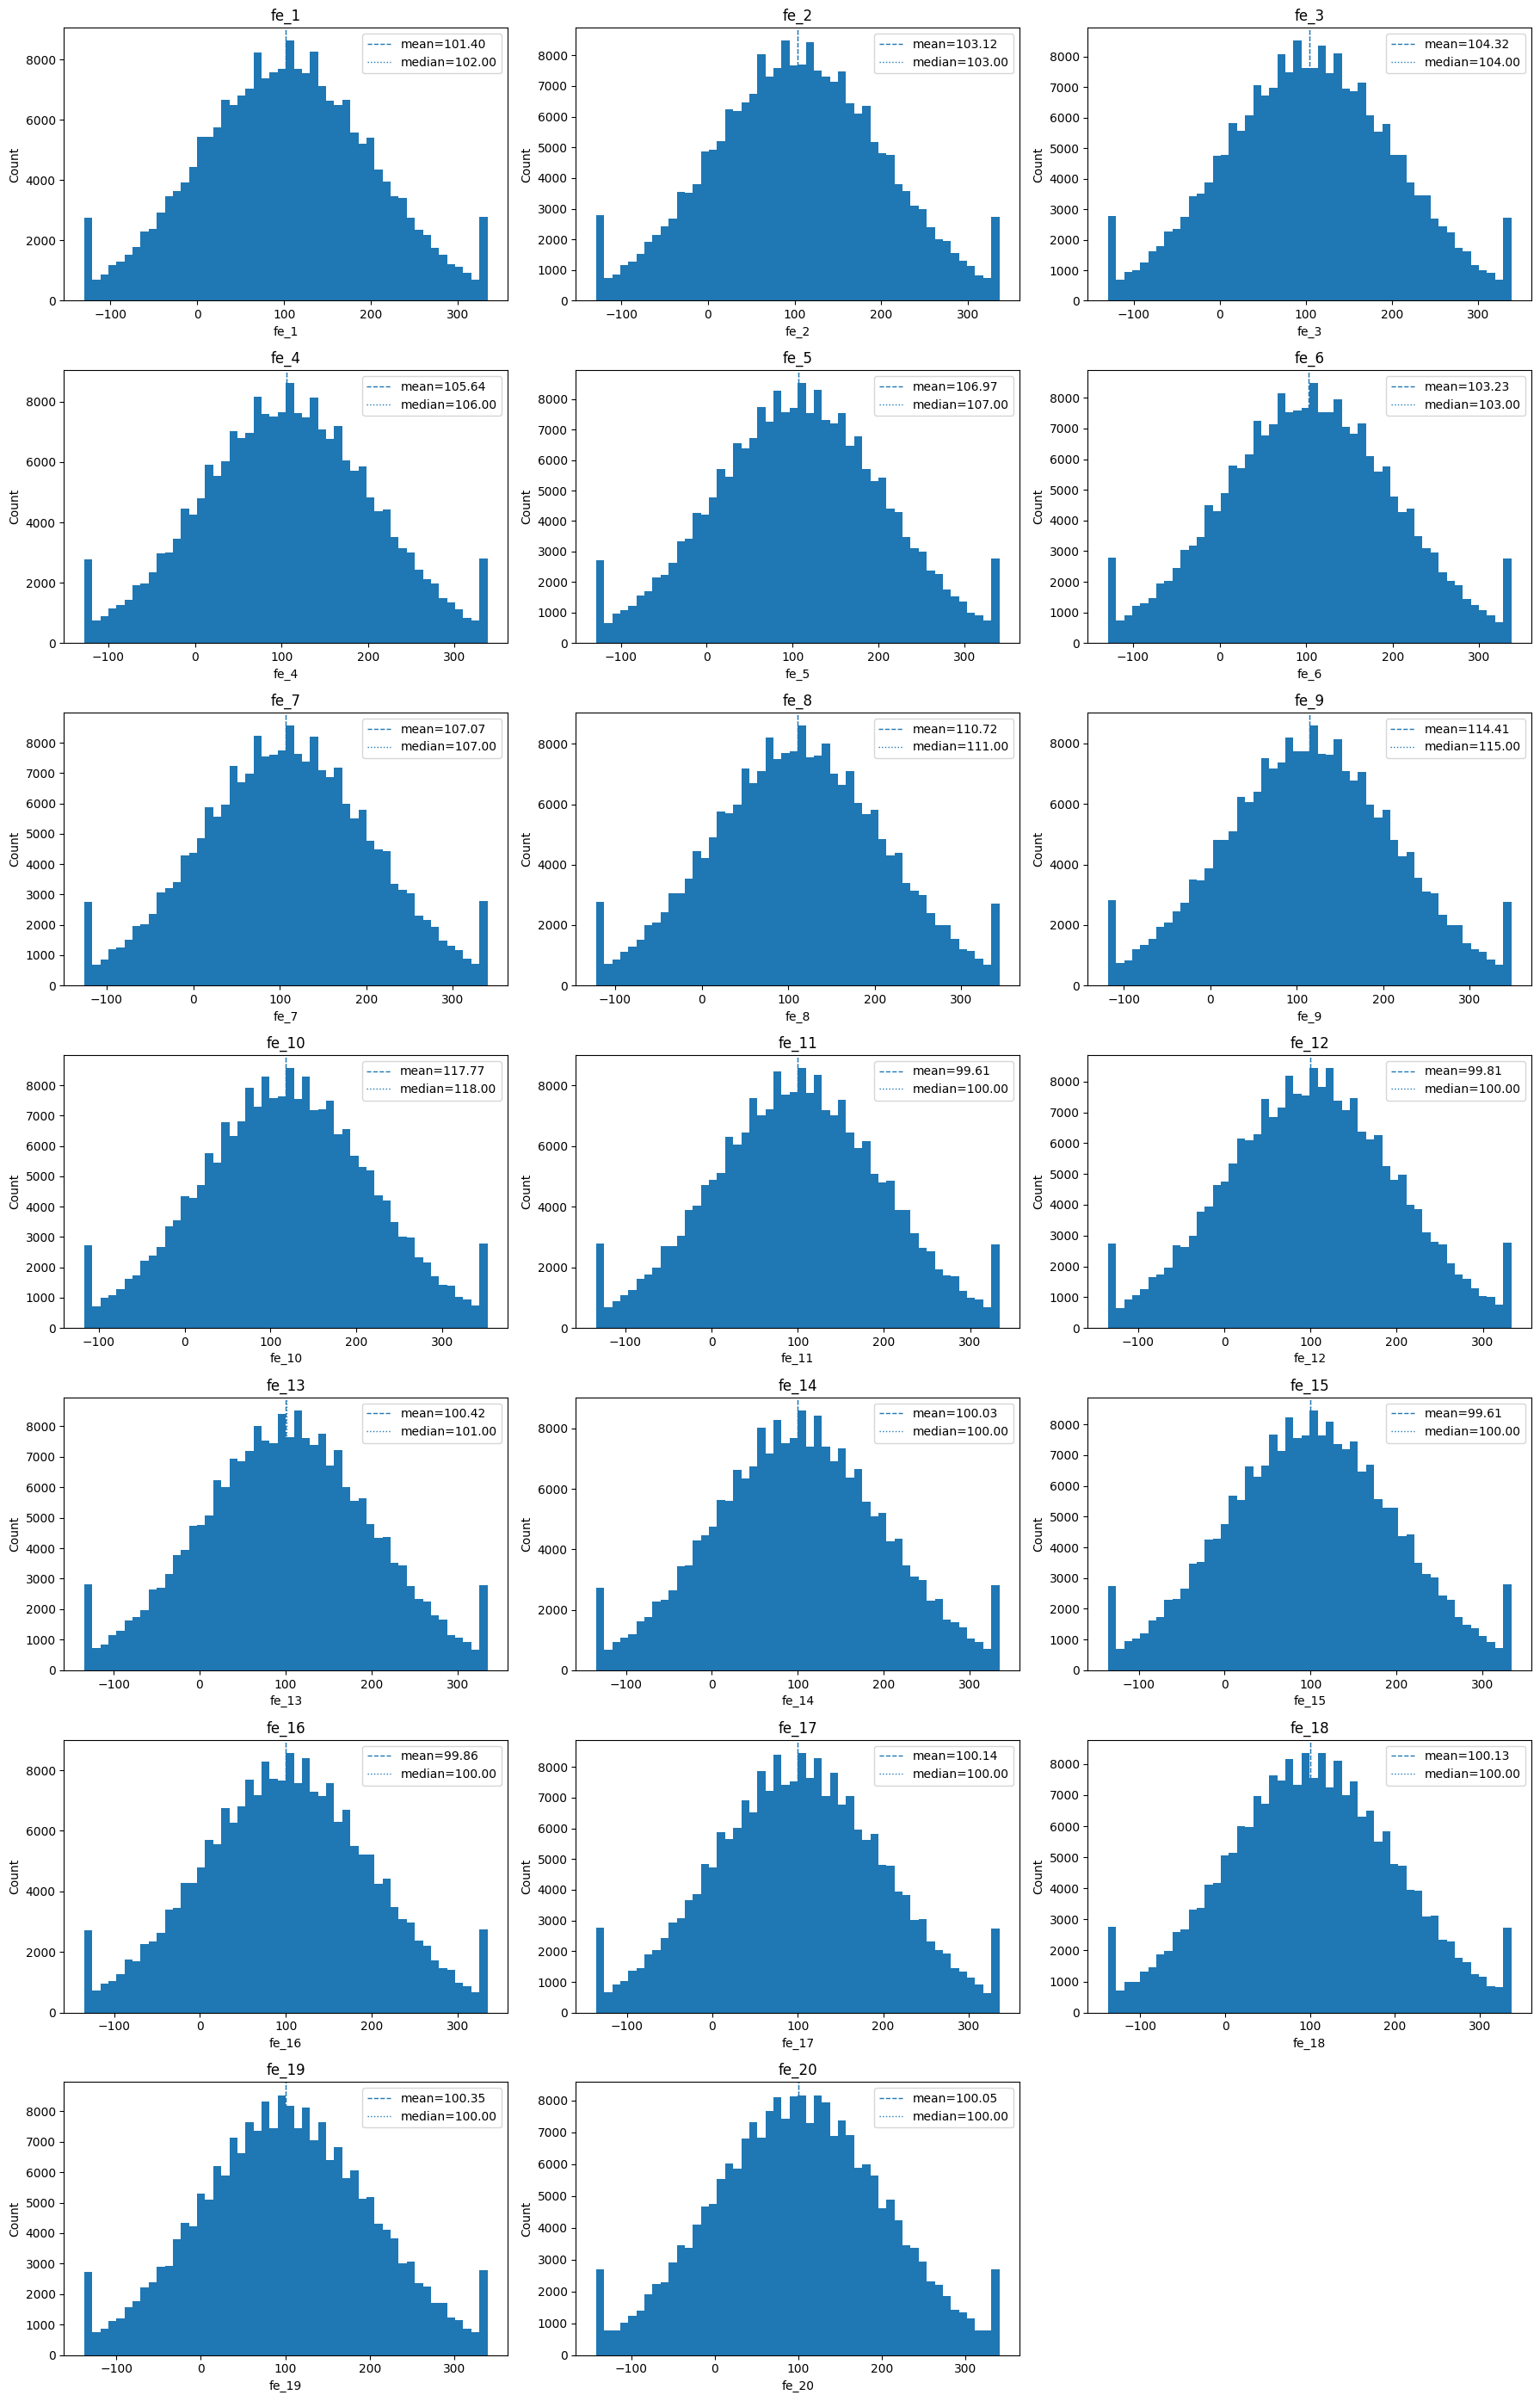


--- FEATURES_ATTRIBUTES KEY FEATURES ---

Categorical features:

Age:
Age
26    364
35    361
32    360
39    360
38    345
28    343
44    343
20    342
25    340
41    340
Name: count, dtype: int64

Occupation:
Occupation
_______          880
Lawyer           828
Architect        795
Engineer         793
Accountant       791
Scientist        789
Teacher          782
Media_Manager    780
Mechanic         780
Developer        780
Name: count, dtype: int64

--- FEATURES_FINANCIALS KEY FEATURES ---

Numerical features summary:


,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000
mean,4188.592303,16.939920,23.172720,73.213360,21.060880,26.695280,32.349265,1488.394291
std,3180.147611,114.350815,132.005866,468.682227,14.863091,184.193829,5.156815,8561.449910
min,303.645417,-1.000000,0.000000,1.000000,-5.000000,0.000000,20.100770,0.000000
25%,1624.937917,3.000000,4.000000,8.000000,10.000000,4.000000,28.066517,31.496968
50%,3087.595000,6.000000,5.000000,14.000000,18.000000,6.000000,32.418953,72.887628
75%,5947.364167,7.000000,7.000000,20.000000,28.000000,10.000000,36.623650,169.634826
max,15204.633333,1756.000000,1499.000000,5789.000000,67.000000,2554.000000,48.199824,81971.000000


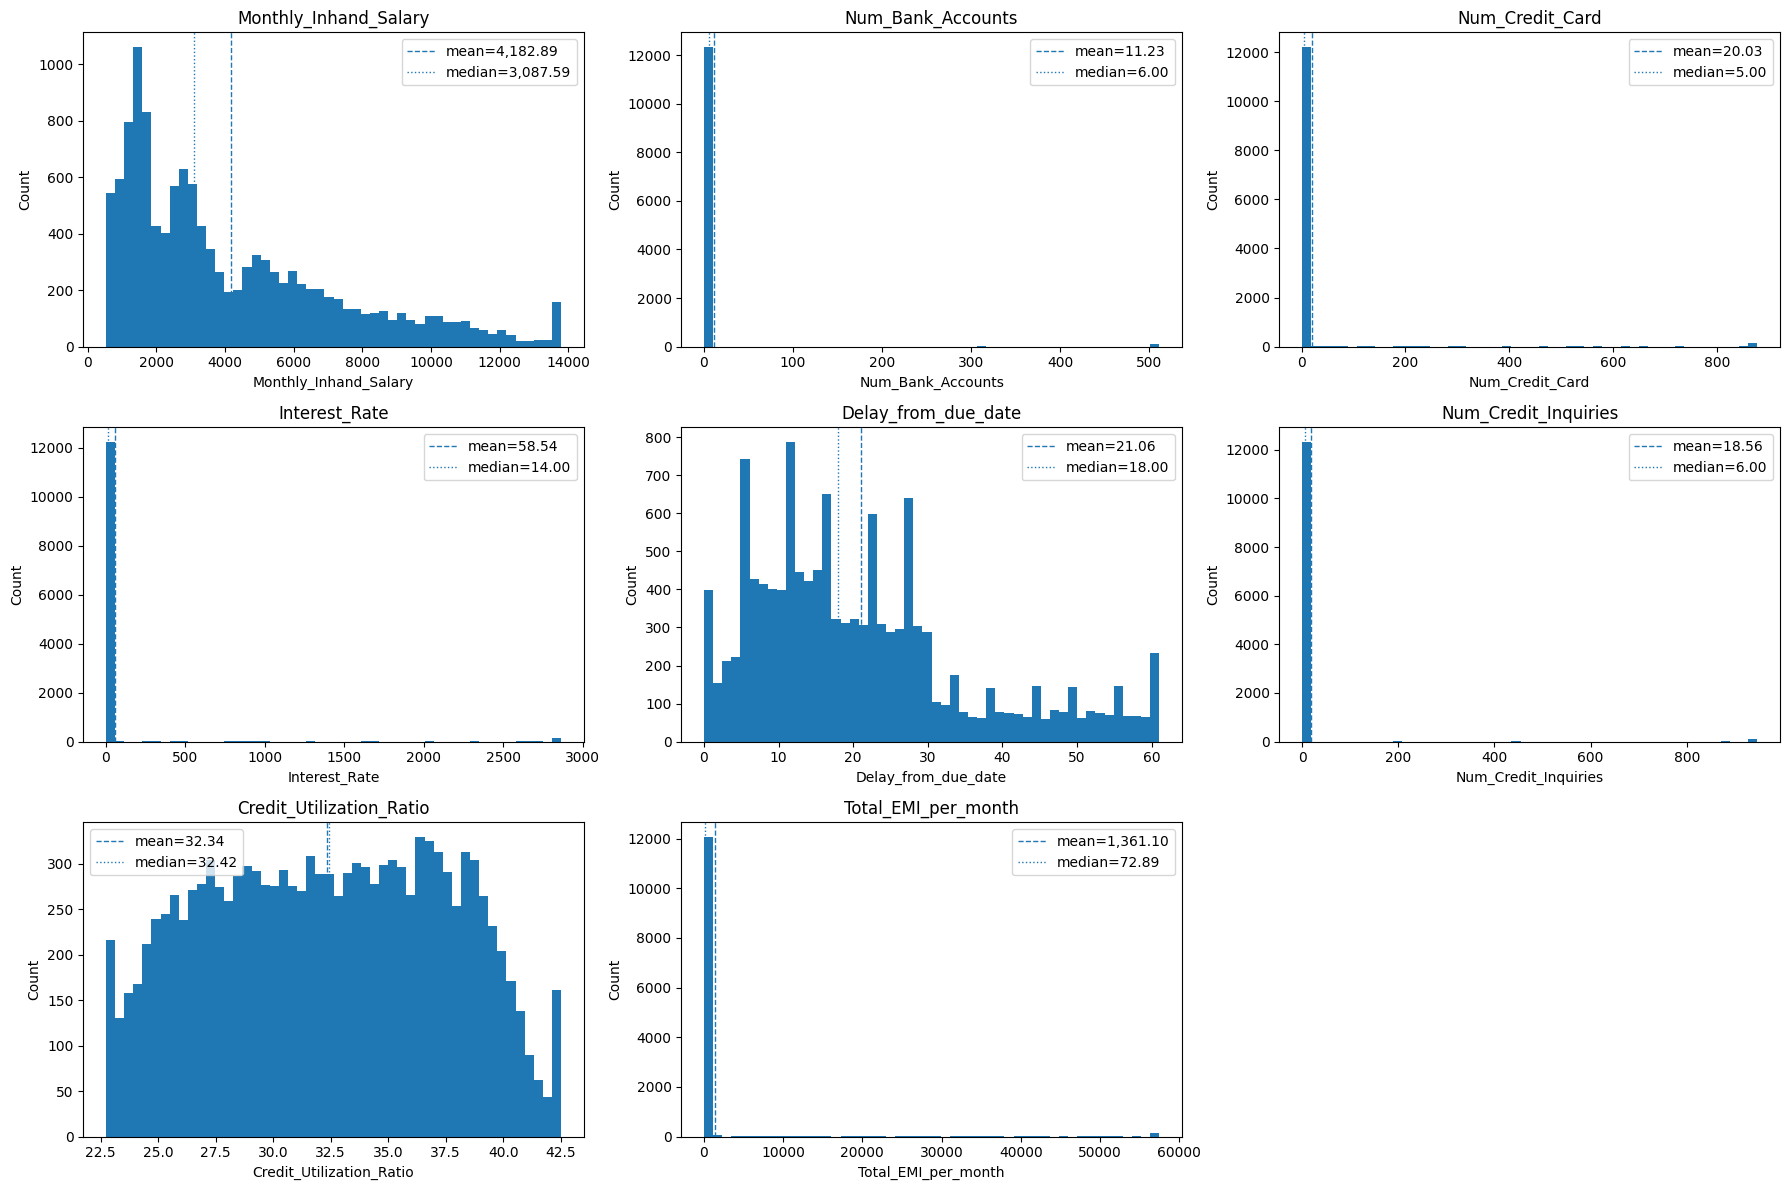


Categorical features:

Annual_Income:
Annual_Income
17273.83     2
109945.32    2
9141.63      2
72524.2      2
20867.67     2
40341.16     2
95596.35     2
36585.12     2
18784.88     1
21719.9      1
Name: count, dtype: int64

Num_of_Loan:
Num_of_Loan
3       1808
2       1769
4       1739
0       1287
1       1260
6        926
7        859
5        849
-100     500
9        435
Name: count, dtype: int64

Type_of_Loan:
Type_of_Loan
NaN                        1426
Not Specified               176
Credit-Builder Loan         160
Personal Loan               159
Debt Consolidation Loan     158
Student Loan                155
Payday Loan                 150
Mortgage Loan               147
Auto Loan                   144
Home Equity Loan            142
Name: count, dtype: int64

Num_of_Delayed_Payment:
Num_of_Delayed_Payment
19    735
16    692
10    690
17    683
18    682
15    680
12    661
20    657
9     653
8     648
Name: count, dtype: int64

Changed_Credit_Limit:
Changed_Credit_Lim

,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance
count,137500.0,137500.000000,137500.0,137500.000000,137500.000000,137500.000000,137500.000000
mean,10.0,5.000000,10000.0,909.090909,711.810909,871.905455,5871.905455
std,0.0,3.162289,0.0,287.480833,485.726859,2002.672544,3070.777575
min,10.0,0.000000,10000.0,0.000000,0.000000,0.000000,0.000000
25%,10.0,2.000000,10000.0,1000.000000,0.000000,0.000000,3000.000000
50%,10.0,5.000000,10000.0,1000.000000,1000.000000,0.000000,7000.000000
75%,10.0,8.000000,10000.0,1000.000000,1000.000000,0.000000,8000.000000
max,10.0,10.000000,10000.0,1000.000000,4000.000000,10000.000000,10000.000000


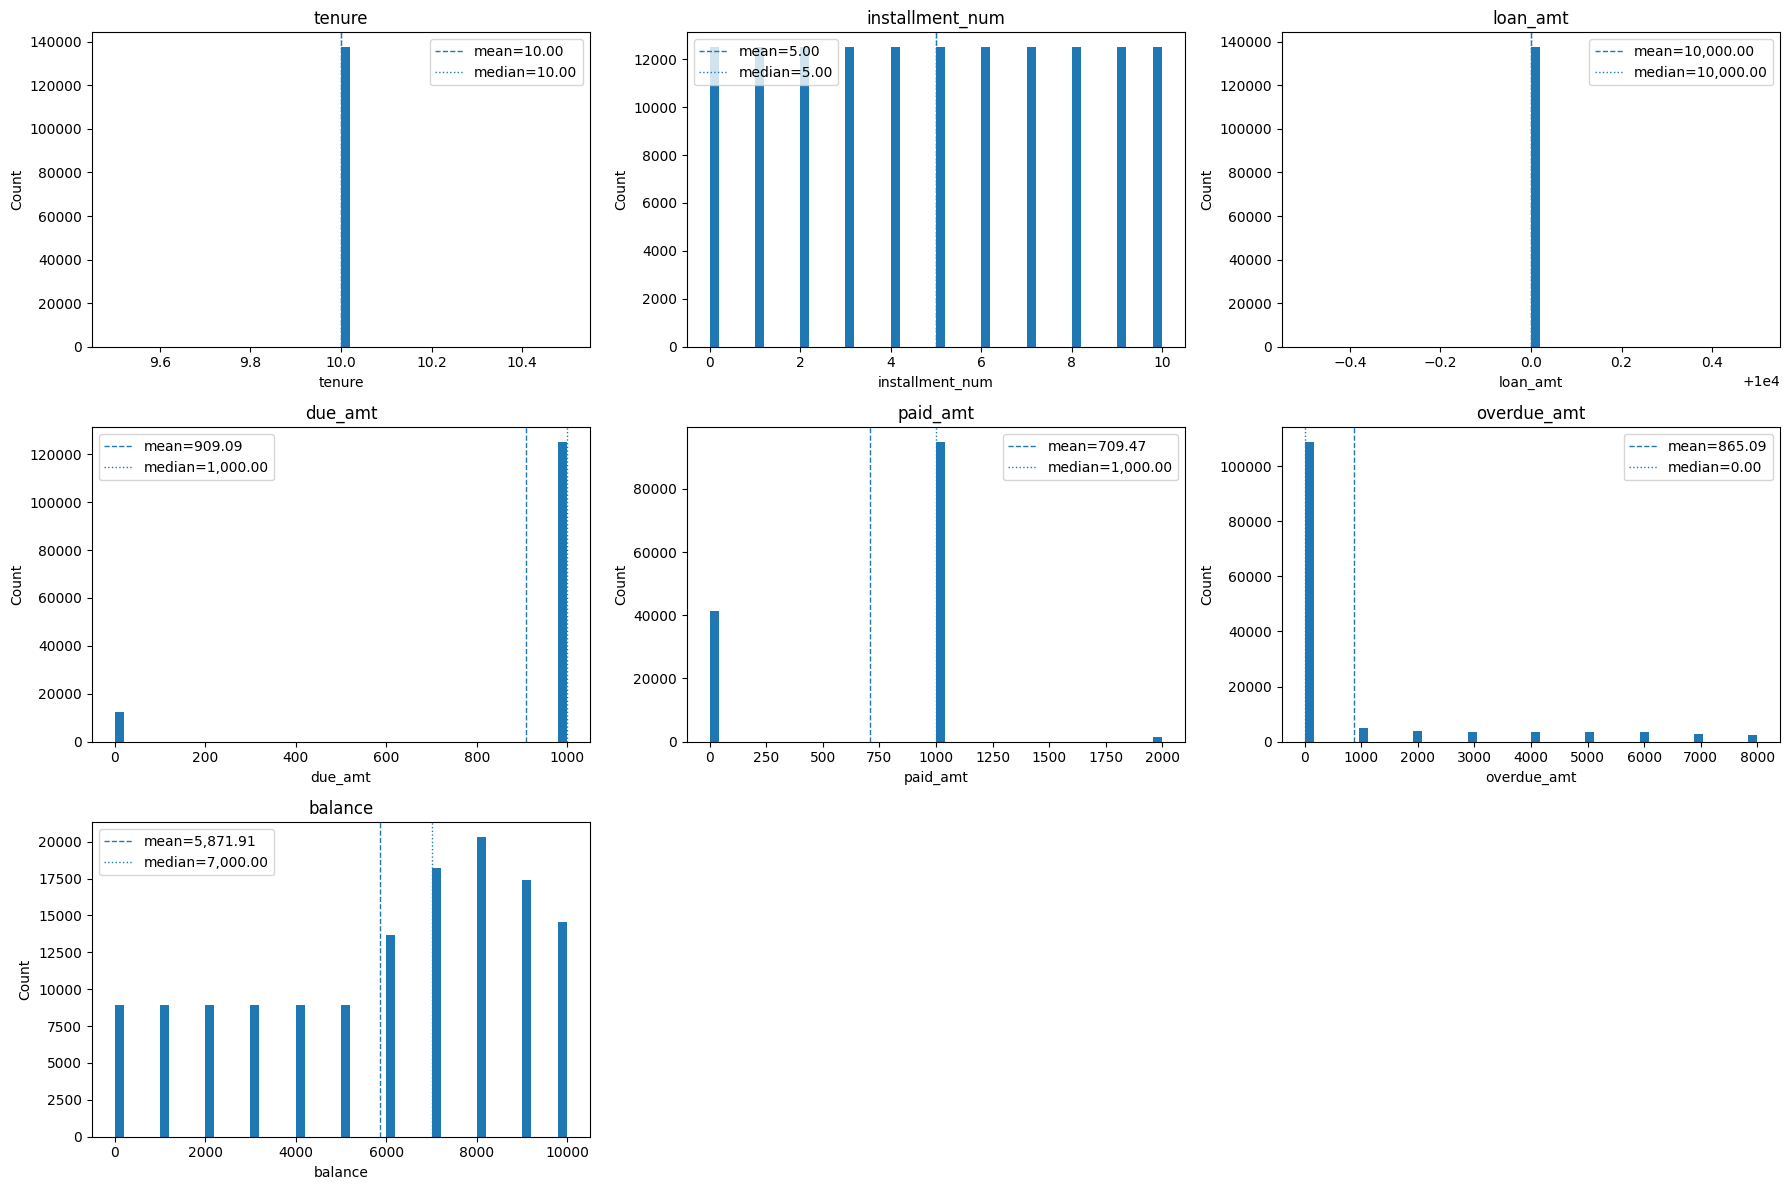


Categorical features:

loan_start_date:
loan_start_date
01/08/2024    5973
01/01/2023    5830
01/01/2025    5786
01/05/2023    5731
01/02/2024    5698
01/06/2023    5687
01/12/2024    5665
01/04/2024    5643
01/03/2024    5621
01/04/2023    5610
Name: count, dtype: int64


In [20]:
analyze_feature_distributions(datasets)

### Data Issues

In [21]:
identify_data_issues(datasets)



--- FEATURE_CLICKSTREAM ISSUES ---


--- FEATURES_ATTRIBUTES ISSUES ---


--- FEATURES_FINANCIALS ISSUES ---


--- LMS_LOAN_DAILY ISSUES ---
⚠ overdue_amt: 28876 potential outliers (21.0%)
⚠ payment_ratio: 30304 potential outliers (22.0%)

📋 Summary: 2 potential issues identified


# Other Explorations

## Features Financials

In [62]:
features_financials.head()

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date
0,CUS_0x1000,30625.94,2706.161667,6,5,27,2,"Credit-Builder Loan, and Home Equity Loan",57,26,1.63,11.0,Bad,1562.91,30.077191,10 Years and 9 Months,Yes,42.941090,77.31427572208112,High_spent_Medium_value_payments,400.36080052211616,2023-05-01
1,CUS_0x1009,52312.68_,4250.390000,6,5,17,4,"Not Specified, Home Equity Loan, Credit-Builde...",5,18,9.73,4.0,_,202.68,40.286997,31 Years and 0 Months,Yes,108.366467,58.66019164829086,High_spent_Medium_value_payments,508.01234122645366,2025-01-01
2,CUS_0x100b,113781.38999999998,9549.782500,1,4,1,0,NaN,14,8,8.34,4.0,Good,1030.2,28.592943,15 Years and 10 Months,No,0.000000,617.0792665202719,High_spent_Small_value_payments,597.8989834797281,2024-03-01
3,CUS_0x1011,58918.47,5208.872500,3,3,17,3,"Student Loan, Credit-Builder Loan, and Debt Co...",27,13,14.42,7.0,Standard,473.14,27.829959,15 Years and 10 Months,Yes,123.434939,383.35084463651407,Low_spent_Medium_value_payments,294.1014665671429,2023-11-01
4,CUS_0x1013,98620.98,7962.415000,3,3,6,3,"Student Loan, Debt Consolidation Loan, and Per...",12,9,1.33,3.0,Good,1233.51,26.524864,17 Years and 10 Months,No,228.018084,332.3337079767732,High_spent_Medium_value_payments,485.8897083704929,2023-12-01


In [65]:
counts = (
    features_financials.groupby('Payment_Behaviour')
      .size()
      .reset_index(name='count')
      .sort_values('count', ascending=False)
)
counts

,Payment_Behaviour,count
6,Low_spent_Small_value_payments,3202
2,High_spent_Medium_value_payments,2242
5,Low_spent_Medium_value_payments,1686
1,High_spent_Large_value_payments,1683
3,High_spent_Small_value_payments,1389
4,Low_spent_Large_value_payments,1300
0,!@9#%8,998


## Loans Daily

In [7]:
lms_loan_daily.head()

,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date
0,CUS_0x1000_2023_05_01,CUS_0x1000,2023-05-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-05-01
1,CUS_0x1000_2023_05_01,CUS_0x1000,2023-05-01,10,1,10000,1000.0,1000.0,0.0,9000.0,2023-06-01
2,CUS_0x1000_2023_05_01,CUS_0x1000,2023-05-01,10,2,10000,1000.0,1000.0,0.0,8000.0,2023-07-01
3,CUS_0x1000_2023_05_01,CUS_0x1000,2023-05-01,10,3,10000,1000.0,0.0,1000.0,8000.0,2023-08-01
4,CUS_0x1000_2023_05_01,CUS_0x1000,2023-05-01,10,4,10000,1000.0,2000.0,0.0,6000.0,2023-09-01


In [8]:
lms_loan_daily.describe()

,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance
count,137500.0,137500.000000,137500.0,137500.000000,137500.000000,137500.000000,137500.000000
mean,10.0,5.000000,10000.0,909.090909,711.810909,871.905455,5871.905455
std,0.0,3.162289,0.0,287.480833,485.726859,2002.672544,3070.777575
min,10.0,0.000000,10000.0,0.000000,0.000000,0.000000,0.000000
25%,10.0,2.000000,10000.0,1000.000000,0.000000,0.000000,3000.000000
50%,10.0,5.000000,10000.0,1000.000000,1000.000000,0.000000,7000.000000
75%,10.0,8.000000,10000.0,1000.000000,1000.000000,0.000000,8000.000000
max,10.0,10.000000,10000.0,1000.000000,4000.000000,10000.000000,10000.000000


**RECOMMENDATIONS**
1. **CREATE TARGET VARIABLE**: Develop a binary default indicator based on overdue amounts and payment patterns,
2. **FEATURE ENGINEERING**: Create derived features like payment_ratio, days_overdue, credit_utilization_risk,
3. **TEMPORAL FEATURES**: Extract time-based features from snapshot_dates and payment histories,
4. **CUSTOMER JOURNEY**: Analyze customer behavior progression over time using clickstream data,
5. **RISK SCORING**: Combine multiple risk indicators into composite risk scores,
6. **DATA VALIDATION**: Implement data quality checks for negative amounts and outliers,
7. **FEATURE SELECTION**: Use correlation analysis and feature importance for model preparation

# Cleaning

In [52]:
# --- Standard libraries ---
import os
import glob
import random
import pprint
import logging
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# --- Data manipulation & analysis ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- PySpark core & types ---
import pyspark
from pyspark.sql import functions as F
from pyspark.sql.functions import col, regexp_replace, trim, when
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, DateType

# --- CLI utilities ---
import argparse

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

def validate_required_columns(df, table_name, required_columns):
    """
    Validate that DataFrame contains all required columns
    
    Args:
        df: Spark DataFrame
        table_name: Name of the table for logging
        required_columns: List of required column names
    
    Raises:
        ValueError: If required columns are missing
    """
    missing_columns = set(required_columns) - set(df.columns)
    
    if missing_columns:
        error_msg = f"Table {table_name} missing required columns: {missing_columns}"
        logger.error(error_msg)
        raise ValueError(error_msg)
    
    logger.info(f"Schema validation passed for {table_name}")

def transform_to_numeric(df, exclude=['Customer_ID','snapshot_date'], numeric_threshold=0.9):
    """
    Financials-specific transformations
    - Auto-detect numeric-looking columns that are strings
    - Remove non-numeric characters and cast to float/int
    - Explicitly cast Annual_Income -> Float, Num_of_Loan -> Int
    """
    try:
        string_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
        candidates = [c for c in string_cols if c not in exclude]

        # --- For each candidate, try to clean & see if most rows cast to number
        for c in candidates:
            # keep digits, sign, and decimal point; drop everything else (spaces, underscores, %, commas, etc.)
            cleaned = regexp_replace(col(c), r'[^0-9\.\-]+', '')
            cleaned = trim(cleaned)

            # empty -> null, then try to cast to double
            cast_col = when(F.length(cleaned) == 0, None).otherwise(cleaned).cast(DoubleType())
            tmp = f"__num_{c}"

            # compute fraction of non-null after cast
            ratio = df.withColumn(tmp, cast_col) \
                      .select((F.count(tmp) / F.count(F.lit(1))).alias("ratio")) \
                      .collect()[0]["ratio"]

            if ratio is not None and ratio >= numeric_threshold:
                # decide int vs float: if all non-null values are whole numbers, make it int
                df_with = df.withColumn(tmp, cast_col)
                max_frac = df_with.select(
                    F.max(F.abs(col(tmp) - F.floor(col(tmp)))).alias("max_frac")
                ).collect()[0]["max_frac"]

                is_integer = (max_frac is None) or (float(max_frac) == 0.0)
                target_type = IntegerType() if is_integer else FloatType()

                df = df_with.drop(c).withColumn(c, col(tmp).cast(target_type)).drop(tmp)
                logger.info(f"Auto-cast '{c}' -> {'Integer' if is_integer else 'Float'} (cleaned non-numeric chars)")
            else:
                logger.info("Kept '%s' as string (only %.2f%% numeric after cleaning)", c, (ratio or 0.0) * 100)

        logger.info("Financials transformations complete.")

        return df

    except Exception as e:
        logger.error(f"Error in transformation: {str(e)}")
        raise

In [39]:
os.getcwd()

'/app/experiments'

In [60]:
from pyspark.sql import SparkSession

# 1️⃣ Start or get an existing Spark session
spark = SparkSession.builder \
    .appName("FinancialsETL") \
    .getOrCreate()

path = '/app/datamart/bronze/features_financials/'

# 2️⃣ Read the CSV file
df = spark.read.csv(path + 
    "bronze_features_financials_2023_03_01.csv",   # path to your file
    header=True,                 # use first row as column names
    inferSchema=True             # try to infer data types automatically
)

# 3️⃣ Show preview
df.show(5)
df.printSchema()


+-----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+-------------+
|Customer_ID|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|snapshot_date|
+-----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+-------

In [61]:
transform_financials(df)

2025-10-06 10:01:29,806 - __main__ - INFO - Auto-cast 'Annual_Income' -> Float (cleaned non-numeric chars)
2025-10-06 10:01:30,092 - __main__ - INFO - Auto-cast 'Num_of_Loan' -> Integer (cleaned non-numeric chars)
2025-10-06 10:01:30,221 - __main__ - INFO - Kept 'Type_of_Loan' as string (only 0.00% numeric after cleaning)
2025-10-06 10:01:30,500 - __main__ - INFO - Auto-cast 'Num_of_Delayed_Payment' -> Integer (cleaned non-numeric chars)
2025-10-06 10:01:30,832 - __main__ - INFO - Auto-cast 'Changed_Credit_Limit' -> Float (cleaned non-numeric chars)
2025-10-06 10:01:30,947 - __main__ - INFO - Kept 'Credit_Mix' as string (only 0.00% numeric after cleaning)
2025-10-06 10:01:31,228 - __main__ - INFO - Auto-cast 'Outstanding_Debt' -> Float (cleaned non-numeric chars)
2025-10-06 10:01:31,473 - __main__ - INFO - Auto-cast 'Credit_History_Age' -> Integer (cleaned non-numeric chars)
2025-10-06 10:01:31,593 - __main__ - INFO - Kept 'Payment_of_Min_Amount' as string (only 0.00% numeric after cle

DataFrame[Customer_ID: string, Monthly_Inhand_Salary: double, Num_Bank_Accounts: int, Num_Credit_Card: int, Interest_Rate: int, Type_of_Loan: string, Delay_from_due_date: int, Num_Credit_Inquiries: double, Credit_Mix: string, Credit_Utilization_Ratio: double, Payment_of_Min_Amount: string, Total_EMI_per_month: double, Payment_Behaviour: string, Monthly_Balance: double, snapshot_date: date, Annual_Income: float, Num_of_Loan: int, Num_of_Delayed_Payment: int, Changed_Credit_Limit: float, Outstanding_Debt: float, Credit_History_Age: int, Amount_invested_monthly: float]

In [50]:
df.head()

Row(Customer_ID='CUS_0x1037', Annual_Income='15989.085', Monthly_Inhand_Salary=1086.42375, Num_Bank_Accounts=5, Num_Credit_Card=4, Interest_Rate=2, Num_of_Loan='4', Type_of_Loan='Credit-Builder Loan, Auto Loan, Auto Loan, and Mortgage Loan', Delay_from_due_date=13, Num_of_Delayed_Payment='15', Changed_Credit_Limit='0.5', Num_Credit_Inquiries=3.0, Credit_Mix='Good', Outstanding_Debt='665.82', Credit_Utilization_Ratio=40.69769934536393, Credit_History_Age='19 Years and 9 Months', Payment_of_Min_Amount='No', Total_EMI_per_month=33.797020629881075, Amount_invested_monthly='80.46523951443457', Payment_Behaviour='Low_spent_Small_value_payments', Monthly_Balance=284.3801148556844, snapshot_date=datetime.date(2023, 1, 1))